# Setup
- Clone repo
- Install requirements
- Imports

In [1]:
import os
import sys

CLONE = True
os.chdir('/kaggle/working')
if CLONE:
    !rm -r rp_2024
    !git clone https://gitlab.com/hiroshan.sliit/rp_2024.git
    os.chdir('./rp_2024')
    w_br = 'hiroshan/text-classification/ssda-testing'
    !git checkout {w_br}
    os.chdir('./text-classification')
else:
    os.chdir('./rp_2024/text-classification')

!pip -qq install -r 'requirements.txt'
!pip install scipy==1.12

script_dir = os.path.abspath(os.path.join(os.getcwd(), 'scripts'))
sys.path.append(script_dir)

rm: cannot remove 'rp_2024': No such file or directory
Cloning into 'rp_2024'...
remote: Enumerating objects: 35842, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 35842 (delta 259), reused 0 (delta 0), pack-reused 35480 (from 1)
Receiving objects: 100% (35842/35842), 152.29 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (1020/1020), done.
Branch 'hiroshan/text-classification/ssda-testing' set up to track remote branch 'hiroshan/text-classification/ssda-testing' from 'origin'.
Switched to a new branch 'hiroshan/text-classification/ssda-testing'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 23.3 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently tak

In [2]:
import pandas as pd
import pickle
from time import time
import re
import random
import warnings
from gensim.models import KeyedVectors
from scripts.augment import VDDA, SSwap
from tqdm.notebook import tqdm_notebook as tqdm
from scripts.preprocess import text_cleaning_pipeline, has_more_than_a_word
from scripts.shap import get_shap_values_as_list
from scripts.evaluate import evaluate_dataset
warnings.filterwarnings('ignore')

# Utils
def save_list_to_pkl(lst,name):
    with open(f"{name}.pkl", 'wb') as f:
        pickle.dump(lst, f)
def read_list_from_pkl(name):
    with open(f"{name}.pkl", 'rb') as f:
        return pickle.load(f)
    
def get_aug_partition(df, factor, part_size, gap, from_parts=False, df_full=None):
    get_i = []
    if from_parts: 
        corrected_idx = [i*gap for i in parts[part_size].index]
    else:
        corrected_idx = [i*gap for i in df_full.index]

    for f in range(0, factor):
        filtered_idx = [i+f for i in corrected_idx]
        for i in range(f, df.shape[0], gap):
            if i in filtered_idx:
                get_i.append(i)    
    return df.iloc[get_i]

def get_results_df(results_dict, existing_df=None, join=False):
    rdf = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in results_dict.items()]))
    cols = rdf.columns
    odf = pd.DataFrame()
    for c in cols:
        split_df = rdf[c].apply(pd.Series)
        if len(split_df.columns) < 2:
            continue
        split_df.columns = [f'{c}_f', f'{c}_a', f'{c}_r', f'{c}_p']
        odf = pd.concat([odf, split_df], axis=1)
    if join:
        odf = pd.concat([existing_df, odf], axis=1)
    return odf

def get_result_metric(rdf, metrics=['f']):
    cols = rdf.columns
    s_cols = []
    for m in metrics:
        for c in cols:
            if str(c).endswith(f"_{m}"):
                s_cols.append(c)
    return rdf[s_cols]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [3]:
# English - Goemotions
s = time()
df = pd.read_csv('data/goemotions.csv')[['text', 'label']] # train data
df['text'] = df.text.apply(text_cleaning_pipeline)
df = df[df['text'].apply(has_more_than_a_word)]
print(f'Total {df.shape[0]} rows of English Reddit comments [{time()-s:.1f}]')

Total 38099 rows of English Reddit comments [15.7]


In [4]:
# Sinhala - ACTSEA
s = time()
df_si = pd.read_excel("data/sin/Sinhala_Emotion_tweets.xlsx")
df_si = pd.DataFrame({'text':df_si['Tweets'], 'label':df_si['Emotion Set'].str.lower()})
label_mapping = {'neutral': 6, 'anger': 1, 'fear': 2, 'surprise': 3, 'happy': 4, 'sadness': 5, 'disgust': 0}
df_si['label'] = df_si.label.replace(label_mapping)
df_si['text'] = df_si.text.apply(lambda t: re.sub(r'[0-9A-Za-z@://.,]', '', t))
df_si.drop_duplicates(subset='text', inplace=True)
df_si = df_si[df_si['text'].apply(has_more_than_a_word)]
print(f"Total {df_si.shape[0]} rows of Sinhala tweets [{time()-s:.1f}]")

Total 915 rows of Sinhala tweets [0.4]


In [5]:
RS = 3236
TRAIN_SIZE = 6000
TRAIN_PCT = .85
TEST_SIZE = 5000

In [6]:
train = df.sample(TRAIN_SIZE, random_state=RS)
test = df.drop(train.index).sample(TEST_SIZE, random_state=RS)
print('English:',train.shape[0], test.shape[0])

English: 6000 5000


In [7]:
train_si = df_si.sample(frac=TRAIN_PCT, random_state=RS)
test_si = df_si.drop(train_si.index)
print('Sinhala:',train_si.shape[0], test_si.shape[0])

Sinhala: 778 137


# Extract SHAP

In [ ]:
# English 
shaps = get_shap_values_as_list(train, test, train)
save_list_to_pkl(shaps_si, 'shaps_train_6000')
with open('data/shaps_raw_6000.pkl', 'rb') as f:
    shaps = pickle.load(f)
shaps = [x[:,0] for x in shaps]
shaps = [x for x in shaps]

# Checking
sample_idx = 10
print(*list(zip(train_si.reset_index().text[sample_idx].split(), shaps_si[sample_idx])), sep='\n')

In [8]:
# Sinhala
shaps_si = get_shap_values_as_list(train_si, test_si, train_si, lr=5e-5, e=50)
save_list_to_pkl(shaps_si, 'shaps_train_si_778')
shaps_si = read_list_from_pkl('shaps_train_si_778')

# Checking
sample_idx = 10
print(*list(zip(train_si.reset_index().text[sample_idx].split(), shaps_si[sample_idx])), sep='\n')

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 107

  0%|          | 0/778 [00:00<?, ?it/s]

778
('බූන්දි', -0.03115411102771759)
('-', -0.03115411102771759)
('|', -0.03115411102771759)
('හීනෙන්', -0.03115411102771759)
('පේනවද', -0.14571889117360115)
('උතුමනි', 0.08341066911816597)
('පෝරකය?', 0.0035025030374526978)
('-', -0.06581072509288788)
('[ඩෝං', -0.03115411102771759)
('පුතා]', -0.03115411102771759)
('පුදුමය', -0.03115411102771759)
('මෙයයි', -0.03115411102771759)
('පිරමිඩ', -0.015577055513858795)
('වුව', -0.015577055513858795)
('වෙයි', -0.015577055513858795)
('දෙවැනීඅරුමය', -0.015577055513858795)


# Creating augmented datasets

## Back-Translation

In [34]:
# from transformers import pipeline

# print("::: Translating src to trg :::\n")
# print("Translating text en to es ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es", device='cuda')
# %time outputs = pipe(list(train.text), batch_size=32, return_text=True, num_return_sequences=4)
# es_sents = [i['translation_text'] for o in outputs for i in o]
# print("Translating text en to de ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-de", device='cuda')
# %time outputs = pipe(list(train.text), batch_size=32, return_text=True, num_return_sequences=4)
# de_sents = [i['translation_text'] for o in outputs for i in o]
# print("Translating text en to fr ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr", device='cuda')
# %time outputs = pipe(list(train.text), batch_size=32, return_text=True, num_return_sequences=4)
# fr_sents = [i['translation_text'] for o in outputs for i in o]
# print("Translating text en to zh ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-zh", device='cuda')
# %time outputs = pipe(list(train.text), batch_size=32, return_text=True, num_return_sequences=4)
# zh_sents = [i['translation_text'] for o in outputs for i in o]
# print("Translating text en to hi ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi", device='cuda')
# %time outputs = pipe(list(train.text), batch_size=32, return_text=True, num_return_sequences=4)
# hi_sents = [i['translation_text'] for o in outputs for i in o]

# [ALT] Read from files 
# es_sents = read_list_from_pkl('es_sents')
# de_sents = read_list_from_pkl('de_sents')
# fr_sents = read_list_from_pkl('fr_sents')
# zh_sents = read_list_from_pkl('zh_sents')

# en_sents = []
# print("\n::: Translating trg to src :::\n")

# print("Translating text es to en ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en", device='cuda', truncation=True)
# %time outputs = pipe(es_sents, batch_size=32, return_text=True, num_return_sequences=1)
# en_sents.append([o['translation_text'] for o in outputs])

# print("Translating text de to en ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en", device='cuda')
# %time outputs = pipe(de_sents, batch_size=32, return_text=True, num_return_sequences=1)
# en_sents.append([o['translation_text'] for o in outputs])

# print("Translating text fr to en ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en", device='cuda')
# %time outputs = pipe(fr_sents, batch_size=32, return_text=True, num_return_sequences=1)
# en_sents.append([o['translation_text'] for o in outputs])

# print("Translating text zh to en ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en", device='cuda')
# %time outputs = pipe(zh_sents, batch_size=32, return_text=True, num_return_sequences=1)
# en_sents.append([o['translation_text'] for o in outputs])

# print("Translating text hi to en ... ")
# pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-hi-en", device='cuda')
# %time outputs = pipe(hi_sents, batch_size=32, return_text=True, num_return_sequences=1)
# en_sents.append([o['translation_text'] for o in outputs])

# save_list_to_pkl(en_sents, 'backtranslated_sents')
# all_en_sents = [sent for sublist in en_sents for sent in sublist]
# save_list_to_pkl(all_en_sents, 'backtranslated_sents_all')
# len(all_en_sents)

# Adding original sents
# all_sents = []
# all_labels = []
# for oi, i in tqdm(enumerate(range(0, len(en_sents[0]), 4)), total=6000):
#     all_sents.append(list(train.text)[oi])
#     for sents in en_sents:
#         all_sents.extend(sents[i:i+4])
#     all_labels.extend([list(train.label)[oi]] * ((4 * len(en_sents) +1)))

# bt_full = pd.DataFrame({'text':all_sents, 'label':all_labels})
# bt_full.to_csv('bt_train_6000.csv', index=False)

bt_full = pd.read_csv("bt_train_6000.csv")
bt_full.loc[bt_full.text.isnull(), 'text'] = bt_full.text[0] 
print("Final BT dataset:", bt_full.shape)  

Final BT dataset: (126000, 2)


Empty DataFrame
Columns: [text, label]
Index: []

## Word Replacement (GloVe-based)

In [119]:
dda_full = pd.read_csv("data/dda_train_si_778_20.csv")
print("Final DDA dataset:", dda_full.shape)

Final DDA dataset: (16338, 2)


In [6]:
# model = KeyedVectors.load_word2vec_format('/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt', binary=False, no_header=True)
# dda_full = VDDA(model).augment_df(train, 20)
# dda_full.to_csv("dda_train_6000_20.csv", index=False)

dda_full = pd.read_csv("dda_train_6000_20.csv")
print("Final DDA dataset:", dda_full.shape)

Final DDA dataset: (126000, 2)


## EDA 

In [ ]:
# English
eda_full = pd.read_csv('data/eda_train_6000_20.csv', delimiter='\t', header=None)
eda_full.columns = ['label', 'text'] # add col headers
eda_full.shape

## SSwap

In [134]:
sswap_full = SSwap().augment_data_bswap(df=train_si, shap_values=shaps_si, factor=20, p=0.1, t=85)
sswap_full.to_csv("sswap_train_si_778_85.csv")
# sswap_full = pd.read_csv("sswap_train_6000_75.csv")
sswap_full.shape


Original: 778 rows


SSwap Progress:   0%|          | 0/778 [00:00<?, ?it/s]

Post-augmentation: 16338 rows


(16338, 2)

# TEST 1: Different Data Sizes 

In [7]:
# Partition data
parts = dict()
for n in range(10, 101, 10):
    parts[n] = train.reset_index(drop=True).sample(n*TRAIN_SIZE//100, random_state=RS)
    print(parts[n].shape[0], end=' ')

parts_r = {'partition_size':list(parts.keys()), 
           'original':[], 'eda':[], 'bt':[], 'dda':[], 'sswap':[]} # For Results

600 1200 1800 2400 3000 3600 4200 4800 5400 6000 

In [ ]:
# Original
# for p, p_data in parts.items():
#     parts_r['original'].append(evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999))

aug_f = 3
s_parts = [10,20,30,40,50,60,70,80,90,100]

# # # EDA
# parts_eda = {p:get_aug_partition(eda_full, aug_f+1, p, 21) for p in parts.keys()}
# for p, p_data in tqdm(parts_eda.items()):
#     if p in s_parts:
#         r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#         print(r[0])
#         parts_r['eda'].append(r)

# # # DDA
# parts_dda = {p:get_aug_partition(dda_full, aug_f+1, p, 21) for p in parts.keys()}
# for p, p_data in parts_dda.items():
#     if p in s_parts:
#         r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#         print(r[0])
#         parts_r['dda'].append(r)

# # # BT
# parts_bt = {p:get_aug_partition(bt_full, aug_f+1, p, 21) for p in parts.keys()}
# for p, p_data in parts_bt.items():
#     if p in s_parts:
#         r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#         print(r[0])
#         parts_r['bt'].append(r)

# SSwap
parts_r['sswap_75'] = []
parts_sswap = {p:get_aug_partition(sswap_full, aug_f+1, p, 21) for p in parts.keys()}
for p, p_data in parts_sswap.items():
    if p in s_parts:
        r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
        print(r[0])
        parts_r['sswap_75'].append(r)
    
parts_r['sswap_80'] = []
parts_sswap = {p:get_aug_partition(sswap_full, aug_f+1, p, 5) for p in parts.keys()}
for p, p_data in parts_sswap.items():
    if p in s_parts:
        r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
        print(r[0])
        parts_r['sswap_80'].append(r)
        
parts_r['sswap_85'] = []
parts_sswap = {p:get_aug_partition(sswap_full, aug_f+1, p, 5) for p in parts.keys()}
for p, p_data in parts_sswap.items():
    if p in s_parts:
        r = evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
        print(r[0])
        parts_r['sswap_85'].append(r)

# Checking
# sswap_full = pd.read_csv('sswap_train_6000_85.csv', index_col=0)
# parts_sswap = {p:get_aug_partition(sswap_full, aug_f+1, p, 5) for p in parts.keys()}
# for p, p_data in parts_sswap.items():
#     if p in [100]:
#         print(p, ':', p_data.shape[0])
#         print(evaluate_dataset(p_data, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.371990662271136


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.4489210673179722


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5766933150820276


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5861085526918387


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6039906409473355


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6083770348048487


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6282641427590484


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6103850243727537


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6187484796377859


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6243495126907007


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.3484745266154387


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.45901653224757494


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5682713749909554


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5315786326261581


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5644224404997814


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5804856934812682


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5736996204640378


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.588123745113525


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.586483665522657


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5839619134263506


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.3484745266154387


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.45901653224757494


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5682713749909554


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5315786326261581


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5644224404997814


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5804856934812682


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.5736996204640378


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
get_result_metric(pd.read_csv('test1_results_v2.csv'))

eda_f      bt_f     dda_f   sswap_f  sswap_75_f
0  0.291306  0.358548  0.344697  0.359008    0.371991
1  0.433213  0.441304  0.425429  0.434450    0.448921
2  0.553662  0.576797  0.553581  0.563203    0.576693
3  0.581298  0.574276  0.574520  0.580718    0.586109
4  0.593751  0.592797  0.594774  0.615340    0.603991
5  0.611114  0.601990  0.602445  0.605507    0.608377
6  0.613290  0.608558  0.607701  0.612169    0.628264
7  0.619551  0.608933  0.602689  0.618634    0.610385
8  0.624997  0.625514  0.611073  0.620247    0.618748
9  0.628511  0.614750  0.617334  0.628956    0.624350

In [ ]:
test1_r = pd.read_csv('test1_results_final.csv', index_col=0)
test1_r

# TEST 2: Different augmentation factors

In [9]:
# Partition data
parts = dict()
for n in range(10, 101, 10):
    parts[n] = train.reset_index(drop=True).sample(n*TRAIN_SIZE//100, random_state=RS)
    print(parts[n].shape[0], end=' ')

# parts_r = {'augmentation_factor':list(range(2,21,2)), 
#            'eda':[], 'bt':[], 'dda':[], 'sswap':[]} # For Results
# parts_r

600 1200 1800 2400 3000 3600 4200 4800 5400 6000 

{'augmentation_factor': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'original': [],
 'eda': [],
 'bt': [],
 'dda': [],
 'sswap': []}

In [ ]:
p = 10 # partition

# EDA
# for i in range(2, 21, 2):
#     train = get_aug_partition(eda_full, i+1, p, 21) 
#     r = evaluate_dataset(train, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#     print(r)
#     parts_r['eda'].append(r)

# for i in range(2, 21, 2):
#     train = get_aug_partition(bt_full, i+1, p, 21) 
#     r = evaluate_dataset(train, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#     print(r)
#     parts_r['bt'].append(r)

# for i in range(2, 21, 2):
#     train = get_aug_partition(dda_full, i+1, p, 21) 
#     r = evaluate_dataset(train, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#     print(r)
#     parts_r['dda'].append(r)

# SSwap
# for i in range(2, 21, 2):
#     train = get_aug_partition(sswap_full, i+1, p, 21) 
#     r = evaluate_dataset(train, test, n_exp=1, n_epochs=1, model_name='distilbert-base-uncased',steps=9999)
#     print(r)
#     parts_r['sswap'].append(r)

In [58]:
# Test 2 Results
test2_r = pd.read_csv('test2_results.csv', index_col=0)
display(test2_r)
print('\nF1-scores\n')
display(get_result_metric(test2_r))

eda_f   eda_a     eda_r     eda_p      bt_f    bt_a      bt_r  \
aug_factor                                                                     
2           0.288824  0.6612  0.314891  0.297220  0.281758  0.6604  0.306739   
4           0.398701  0.7004  0.409487  0.389335  0.394626  0.6958  0.406045   
6           0.383783  0.6850  0.393678  0.377521  0.402829  0.6926  0.401968   
8           0.468260  0.6878  0.453246  0.554164  0.487219  0.7156  0.469101   
10          0.485009  0.7050  0.476184  0.517246  0.466619  0.7030  0.451193   
12          0.514430  0.6930  0.507900  0.532404  0.514438  0.7030  0.486001   
14          0.508218  0.7056  0.500543  0.550289  0.529311  0.7138  0.504775   
16          0.531585  0.7020  0.531708  0.536888  0.539581  0.7080  0.534600   
18          0.535489  0.7142  0.512759  0.570384  0.523613  0.7030  0.498070   
20          0.542003  0.7092  0.536458  0.556810  0.536019  0.7020  0.519913   

                bt_p     dda_f   dda_a     dda_r     dda_p   sswap_f  sswap_a  \
aug_factor                                                                      
2           0.462224  0.244164  0.6316  0.286937  0.477026  0.298183   0.6584   
4           0.387279  0.379619  0.6840  0.386123  0.375341  0.394761   0.6944   
6           0.552771  0.383079  0.6808  0.395350  0.372529  0.453385   0.6840   
8           0.584430  0.426826  0.6846  0.420452  0.507331  0.503140   0.7066   
10          0.541694  0.485453  0.7012  0.468993  0.525895  0.502668   0.7040   
12          0.582307  0.505936  0.6912  0.484833  0.546191  0.516563   0.6848   
14          0.574678  0.493366  0.7028  0.475080  0.529376  0.512583   0.7004   
16          0.553281  0.504020  0.7066  0.485902  0.543211  0.530228   0.7102   
18          0.592184  0.516408  0.7072  0.500965  0.552062  0.519185   0.7016   
20          0.562064  0.514322  0.6930  0.503656  0.539375  0.546596   0.7072   

             sswap_r   sswap_p  
aug_factor                      
2           0.320923  0.459509  
4           0.407221  0.384715  
6           0.437110  0.523857  
8           0.480450  0.562791  
10          0.478774  0.567057  
12          0.507628  0.533944  
14          0.502536  0.542678  
16          0.521125  0.542481  
18          0.495157  0.577271  
20          0.536440  0.564059


F1-scores



eda_f      bt_f     dda_f   sswap_f
aug_factor                                        
2           0.288824  0.281758  0.244164  0.298183
4           0.398701  0.394626  0.379619  0.394761
6           0.383783  0.402829  0.383079  0.453385
8           0.468260  0.487219  0.426826  0.503140
10          0.485009  0.466619  0.485453  0.502668
12          0.514430  0.514438  0.505936  0.516563
14          0.508218  0.529311  0.493366  0.512583
16          0.531585  0.539581  0.504020  0.530228
18          0.535489  0.523613  0.516408  0.519185
20          0.542003  0.536019  0.514322  0.546596

# TEST 3: Different Language (Sinhala and Tamil) 

In [135]:
# Sinhala Test
# r = {}

# r['original'] = []
# result = evaluate_dataset(train_si, test_si, n_exp=1, n_epochs=1, model_name='distilbert-base-multilingual-cased',steps=100)
# print(result)
# r['original'].append(result)

# r['dda'] = []   
# for i in range(2, 21, 1):
#     part = get_aug_partition(dda_full, i+1, 100, 21, from_parts=False, df_full=train_si) 
#     result = evaluate_dataset(part, test_si, n_exp=1, n_epochs=1, model_name='distilbert-base-multilingual-cased',steps=100)
#     r['dda'].append(result)
    
r['sswap85'] = []   
for i in range(2, 21, 1):
    part = get_aug_partition(sswap_full, i+1, 100, 21, from_parts=False, df_full=train_si) 
    result = evaluate_dataset(part, test_si, n_exp=1, n_epochs=1, model_name='distilbert-base-multilingual-cased',steps=100)
    r['sswap85'].append(result)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [168]:
t3 = get_results_df(r)
t3['aug_factor'] = list(range(2, 21, 1))
t3['sswap_f'] = t3.apply(lambda r: max(r[['sswap80_f', 'sswap75_f', 'sswap85_f']]), axis=1)
t3['sswap_a'] = t3.apply(lambda r: max(r[['sswap80_a', 'sswap75_a', 'sswap85_a']]), axis=1)
t3['sswap_p'] = t3.apply(lambda r: max(r[['sswap80_p', 'sswap75_p', 'sswap85_p']]), axis=1)
t3['sswap_r'] = t3.apply(lambda r: max(r[['sswap80_r', 'sswap75_r', 'sswap85_r']]), axis=1)
t3 = t3[t3.aug_factor.isin(list(range(2, 21, 2)))]

display(t3[[c for c in t3.columns if c.startswith('sswap_') or c.startswith('dda_')]])
t3 = pd.read_csv('test3_results.csv')
t3.drop(index=9, inplace=True)

dda_f     dda_a     dda_r     dda_p   sswap_f   sswap_a   sswap_p  \
0   0.204575  0.240876  0.276121  0.194640  0.177925  0.240876  0.359386   
2   0.170868  0.226277  0.263981  0.336716  0.262547  0.284672  0.381473   
4   0.229716  0.262774  0.301472  0.317032  0.266699  0.284672  0.289971   
6   0.268115  0.291971  0.309909  0.302275  0.289929  0.321168  0.375235   
8   0.248119  0.270073  0.294651  0.254833  0.280024  0.291971  0.300584   
10  0.262044  0.284672  0.307218  0.323884  0.308228  0.328467  0.328365   
12  0.249683  0.262774  0.286025  0.260446  0.314331  0.328467  0.325504   
14  0.234055  0.255474  0.268990  0.241443  0.286934  0.291971  0.311483   
16  0.237254  0.262774  0.293064  0.231865  0.282101  0.306569  0.297477   
18  0.287847  0.313869  0.350840  0.301945  0.289256  0.299270  0.310788   

     sswap_r  
0   0.283437  
2   0.321417  
4   0.308322  
6   0.334115  
8   0.326104  
10  0.324385  
12  0.353750  
14  0.292535  
16  0.333805  
18  0.311715

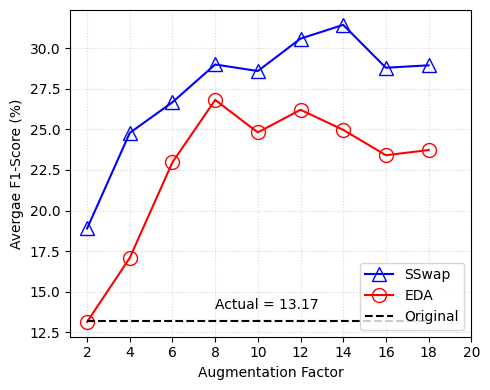

In [170]:
import matplotlib.pyplot as plt
# Plot the graph
plt.figure(figsize=(5, 4))

df = t3
original = 13.17
# Plot each method
plt.plot(df.aug_factor, df['sswap_f']*100, marker='^', label='SSwap', color='blue', markersize=10, markerfacecolor='none')
plt.plot(df.aug_factor, df['dda_f']*100, marker='o', label='EDA', color='red', markersize=10, markerfacecolor='none')
plt.hlines(original, label='Original', color='black', linestyle='--', xmin=2, xmax=18)
plt.xlabel('Augmentation Factor')
plt.xticks(range(2, 22, 2))
plt.ylabel('Avergae F1-Score (%)')
plt.annotate(f"Actual = {original}", xy=(15, original), xytext=(8, original + .75),
             textcoords='data',
             fontsize=10, color='black')
# plt.title('Comparison of F-Score for SSwap, DDA, and Original Methods')
plt.legend(loc='lower right')
plt.grid(True, linestyle='dotted', alpha=.5)
plt.tight_layout()
plt.show()

# Extras

In [104]:
filenames = [f for f in os.listdir() if f.endswith('.csv')]
import zipfile
with zipfile.ZipFile('train_files.zip', 'w') as zipf:
    for file in filenames:
        zipf.write(file)